## Linear Gaussian example

The function is $y=\theta_{0} + \theta_{1} x + \theta_{2} x^2 + \epsilon = X \theta + \epsilon$, where $X$ contains the necessary powers of $x$. The NN is composed simply of 2 inputs and 1 output, no hidden layer.

The prior is chosen to be Gaussian, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior})  $, and so is the noise $\epsilon \sim N(\cdot; 0, \sigma_{n}^{2} I)$. Then the posterior of the parameters can be computed analytically as:

\begin{align*}
& p(\theta \vert D={x,y}) =  N(\cdot; \theta_{post}(D), \Sigma_{post}(D)) \\
& \theta_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1} \left(\frac{1}{\sigma_{n}^{2}}X^{T}y+\Sigma^{-1}\theta_{prior} \right) \\
& \Sigma_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1}
\end{align*}

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.examples_utils import *
from scipy.stats import multivariate_normal

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# compute the true posterior pdf based on available data
def compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n):
    X = np.concatenate([np.ones((xn.shape[0], 1)), xn], axis=1)
    
    # compute posterior pdf
    S_posterior = np.linalg.inv(1/var_n*np.matmul(X.T,X)+np.linalg.inv(S_prior))
    m_posterior = np.matmul(
        S_posterior, 
        1/var_n*np.matmul(X.T, yn)+np.matmul(np.linalg.inv(S_prior), m_prior.reshape((-1,1)))
        )
    m_posterior = m_posterior.reshape((-1,))
    return m_posterior, S_posterior

def compute_gaussian_pdf(x, mean, std):
    log2pi = np.log(2 * np.pi).astype(np.float32)
    return np.exp(- 0.5 * log2pi - np.log(std) - 0.5 * np.square(np.divide(np.subtract(x, mean), std)))

### Define the problem, generate the data and compute true posterior pdf

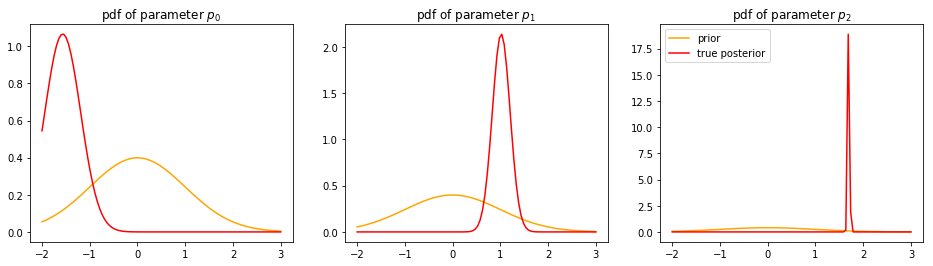

In [3]:
# define the problem
var_n = 1.
f = lambda x, noisy: (-1.5+1.*x[:, 0]+1.7*x[:, 1]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([xn, xn ** 2], axis=1)
yn = f(xn, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter $p_{}$'.format(p))
ax[2].legend()
plt.show(fig)

In [4]:
# define the network
units_per_layer = () # no hidden layers
prior = {'type': 'gaussian', 'variance': [1]} # only needed for output layer
pre_model = None
#pre_model = build_scaling_layers(X_train=xn)

In the following we test several algorihtms and look at the posterior pdf (in particular uncertainty on parameter p2 should be smaller than uncertainty on parameter p0).

In [5]:
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *

### Test BayesByBackprop

In [6]:
reg = BayesByBackprop(units_per_layer=units_per_layer, prior=prior, pre_model=pre_model, 
                      input_dim=2, output_dim=1, 
                      var_n=var_n, activation='linear')
reg.fit(X=xn, y=yn, ns=20, verbose=False, epochs=500, lr=0.002)

[None, None, 2]
[None, None, 2]
[None, 2, 1]
[None, 1]
[None, None, 1]
[None, None, 1]
pass 1
pass 2
pass 3
pass 4
[<tf.Variable 'mu_kernel_layer_0:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'rho_kernel_layer_0:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'mu_bias_layer_0:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'rho_bias_layer_0:0' shape=(1,) dtype=float32_ref>]
[(array([[ -16192.577],
       [-124703.59 ]], dtype=float32), array([[0.23033199],
       [0.12878563]], dtype=float32)), (array([[ 6.2151628],
       [25.56677  ]], dtype=float32), array([[-6.],
       [-6.]], dtype=float32)), (array([-2257.1445], dtype=float32), array([0.29526958], dtype=float32)), (array([-1.6953955], dtype=float32), array([-6.], dtype=float32))]
[(array([[ -16174.183],
       [-124564.36 ]], dtype=float32), array([[0.23233199],
       [0.13078563]], dtype=float32)), (array([[ 1.8108546],
       [87.962006 ]], dtype=float32), array([[-6.002],
       [-5.998]], dtype=float32)), (array([-2254

[(array([[ -14665.754],
       [-113095.24 ]], dtype=float32), array([[0.36245942],
       [0.26093823]], dtype=float32)), (array([[  2.3341289],
       [-33.428185 ]], dtype=float32), array([[-5.974908],
       [-6.008553]], dtype=float32)), (array([-2036.5991], dtype=float32), array([0.42732581], dtype=float32)), (array([-1.0036827], dtype=float32), array([-5.9130054], dtype=float32))]
[(array([[ -14643.223],
       [-112923.93 ]], dtype=float32), array([[0.36438772],
       [0.2628675 ]], dtype=float32)), (array([[  2.025366],
       [-36.29384 ]], dtype=float32), array([[-5.9750032],
       [-6.0089726]], dtype=float32)), (array([-2033.345], dtype=float32), array([0.42925134], dtype=float32)), (array([-1.020716], dtype=float32), array([-5.9118567], dtype=float32))]
[(array([[ -14622.654],
       [-112768.37 ]], dtype=float32), array([[0.36631438],
       [0.26479518]], dtype=float32)), (array([[ -1.8199849],
       [-10.329411 ]], dtype=float32), array([[-5.97498  ],
       [-6.008

[(array([[ -13069.958],
       [-100963.14 ]], dtype=float32), array([[0.5011078 ],
       [0.39971796]], dtype=float32)), (array([[-5.94353  ],
       [-3.5414286]], dtype=float32), array([[-5.983012 ],
       [-5.9867373]], dtype=float32)), (array([-1806.068], dtype=float32), array([0.5655995], dtype=float32)), (array([0.44502443], dtype=float32), array([-5.8213058], dtype=float32))]
[(array([[ -13053.774],
       [-100841.195]], dtype=float32), array([[0.50292486],
       [0.40153766]], dtype=float32)), (array([[-8.1525545],
       [50.387104 ]], dtype=float32), array([[-5.9832106],
       [-5.9865165]], dtype=float32)), (array([-1803.6765], dtype=float32), array([0.56740904], dtype=float32)), (array([-2.1942022], dtype=float32), array([-5.81998], dtype=float32))]
[(array([[ -13024.832],
       [-100619.484]], dtype=float32), array([[0.5047404 ],
       [0.40335587]], dtype=float32)), (array([[ -2.6090224],
       [-40.806202 ]], dtype=float32), array([[-5.9833245],
       [-5.98629

[(array([[-11660.325],
       [-90245.83 ]], dtype=float32), array([[0.62288624],
       [0.52173805]], dtype=float32)), (array([[ -4.3024683],
       [-47.699585 ]], dtype=float32), array([[-5.953403],
       [-6.000333]], dtype=float32)), (array([-1602.4386], dtype=float32), array([0.6866862], dtype=float32)), (array([-2.7696836], dtype=float32), array([-5.7416263], dtype=float32))]
[(array([[-11648.19],
       [-90153.13]], dtype=float32), array([[0.62459683],
       [0.52345306]], dtype=float32)), (array([[6.8855753],
       [6.983559 ]], dtype=float32), array([[-5.953137],
       [-6.000415]], dtype=float32)), (array([-1600.7053], dtype=float32), array([0.6883841], dtype=float32)), (array([-0.8599324], dtype=float32), array([-5.7405434], dtype=float32))]
[(array([[-11628.863],
       [-90006.34 ]], dtype=float32), array([[0.6263058],
       [0.5251665]], dtype=float32)), (array([[ 4.986864],
       [12.49631 ]], dtype=float32), array([[-5.9529514],
       [-6.000419 ]], dtype=floa

[(array([[-10201.806],
       [-79156.35 ]], dtype=float32), array([[0.74998236],
       [0.6492598 ]], dtype=float32)), (array([[ 1.5273864],
       [20.310265 ]], dtype=float32), array([[-5.9488473],
       [-5.986843 ]], dtype=float32)), (array([-1391.7856], dtype=float32), array([0.8125592], dtype=float32)), (array([-0.36248878], dtype=float32), array([-5.6483326], dtype=float32))]
[(array([[-10180.151],
       [-78991.42 ]], dtype=float32), array([[0.751571 ],
       [0.6508552]], dtype=float32)), (array([[ 5.463895],
       [-8.421831]], dtype=float32), array([[-5.9487762],
       [-5.986703 ]], dtype=float32)), (array([-1388.6633], dtype=float32), array([0.8141285], dtype=float32)), (array([-1.7783645], dtype=float32), array([-5.64685], dtype=float32))]
[(array([[-10152.539],
       [-78780.16 ]], dtype=float32), array([[0.75315803],
       [0.65244895]], dtype=float32)), (array([[  7.6409283],
       [-85.707695 ]], dtype=float32), array([[-5.948809 ],
       [-5.9864964]], dty

[(array([[ -8868.418],
       [-69018.42 ]], dtype=float32), array([[0.86466104],
       [0.7645341 ]], dtype=float32)), (array([[-12.473405],
       [-19.159534]], dtype=float32), array([[-5.925203 ],
       [-5.9760456]], dtype=float32)), (array([-1199.2063], dtype=float32), array([0.9255202], dtype=float32)), (array([-0.27447206], dtype=float32), array([-5.5616674], dtype=float32))]
[(array([[ -8860.856],
       [-68961.82 ]], dtype=float32), array([[0.8661286 ],
       [0.76601094]], dtype=float32)), (array([[-7.019455],
       [43.082638]], dtype=float32), array([[-5.924569 ],
       [-5.9761825]], dtype=float32)), (array([-1198.0653], dtype=float32), array([0.926961], dtype=float32)), (array([-1.9730625], dtype=float32), array([-5.5607944], dtype=float32))]
[(array([[ -8837.077],
       [-68778.38 ]], dtype=float32), array([[0.86759466],
       [0.7674863 ]], dtype=float32)), (array([[  1.314606],
       [-19.159883]], dtype=float32), array([[-5.9239116],
       [-5.976463 ]], dt

[(array([[ -7826.7314],
       [-61098.21  ]], dtype=float32), array([[0.95528656],
       [0.8558279 ]], dtype=float32)), (array([[-8.610853],
       [30.228659]], dtype=float32), array([[-5.886314],
       [-5.986793]], dtype=float32)), (array([-1048.7551], dtype=float32), array([1.0142133], dtype=float32)), (array([-0.65671563], dtype=float32), array([-5.4785833], dtype=float32))]
[(array([[ -7803.092],
       [-60917.566]], dtype=float32), array([[0.956649  ],
       [0.85720205]], dtype=float32)), (array([[ -2.385169],
       [-22.744331]], dtype=float32), array([[-5.886244],
       [-5.986511]], dtype=float32)), (array([-1045.3695], dtype=float32), array([1.0155418], dtype=float32)), (array([-2.1863167], dtype=float32), array([-5.476879], dtype=float32))]
[(array([[ -7787.6074],
       [-60799.035 ]], dtype=float32), array([[0.95800984],
       [0.8585746 ]], dtype=float32)), (array([[ -0.5567588],
       [-25.769554 ]], dtype=float32), array([[-5.8862634],
       [-5.98633  ]], 

[(array([[ -6811.8535],
       [-53379.875 ]], dtype=float32), array([[1.0429267],
       [0.944343 ]], dtype=float32)), (array([[ 6.4789767],
       [25.268135 ]], dtype=float32), array([[-5.8606687],
       [-5.9834895]], dtype=float32)), (array([-902.25024], dtype=float32), array([1.0993141], dtype=float32)), (array([-1.9867808], dtype=float32), array([-5.3780384], dtype=float32))]
[(array([[ -6803.4414],
       [-53316.38  ]], dtype=float32), array([[1.0441785],
       [0.9456092]], dtype=float32)), (array([[ 4.143862],
       [59.440384]], dtype=float32), array([[-5.860852 ],
       [-5.9832234]], dtype=float32)), (array([-901.0233], dtype=float32), array([1.1005237], dtype=float32)), (array([-0.9116438], dtype=float32), array([-5.3768897], dtype=float32))]
[(array([[ -6775.8784],
       [-53105.79  ]], dtype=float32), array([[1.0454285],
       [0.9468738]], dtype=float32)), (array([[ 3.2443566],
       [-9.155473 ]], dtype=float32), array([[-5.860904],
       [-5.982837]], dtype

### Test alpha-BB algorithm

In [7]:
### Test bootstrap with randomized prior functions

In [8]:
print((1, 2)+(3,))

(1, 2, 3)
